# Animating Optimization - Using GraphvizAnim to Visualize DAG based Common Subexpression Elimination

#### Maxim Vasiliev - 400043983
#### Susie Yu - 0955758

We first researched different methods of code optimization and assessed their adherence to the objectives of this report. Many techniques entail instruction level optimization which is primarily described by textual sequences of instructions comparing pre and post optimized code. While entirely relevant to compiler optimization, these techniques are hard to visualize using animation due to the fact that most optimizations are simply textual rewrites of the sequence of generated instructions. One optimization type however lends itself naturally to a graph based algorithmic and visual approach.

Common subexpression elimination posits that encountered expressions need not be computed if an equivalent expression has been computed before. To this end, a Directed Acyclic Graph can be constructed based upon the sequence of instructions. If the expression has not been encountered, a node is created for that expression. Otherwise, if an equivalent expression has been encountered before, no node is created but instead the equivalent one is returned. 

We implemented our algorithm using a testing environment and language where we provided the sequence of strings to construct expressions. This approach serves to demonstrate the algorithm at hand, whereby one can construct a reduced DAG of instructions consisting of no duplicate subtrees. Our input is a sequence of assignment expressions of either the form “x = y op z” or “x = op y”. Each expression is then parsed and nodes are created and either linked to the rest of the growing DAG, or the expression is found to be equivalent to a previous one, and a referral is attached to the new node to indicate which node it is equivalent to. This referral is then used while building the graph to effectively eliminate the expression.

Given an input such as “x = y + z”, the algorithm first checks if a node exists with the identifier “y’, if not a node is created with the label and identifier of “y”. The procedure occurs for “z”. Next the algorithm checks if a node exists with the label “+” whose left and right children are “y” and “z”. If the the node exists, it is updated to have  “x” as an additional identifier for that node, and the new node is given the index of this previous node it is equivalent to. Otherwise if the node does not exist, it is created with the label “+”, identifier “x”, left and right children “y” and “z”, and a referral to itself instead of any other node, indicating that it is the first node of that expression. Once the nodes are created logically, they are traversed to build the reduced DAG.
	
In order to visualize the optimization algorithm we assessed a number of different python libraries on their ability to generate and animate graphs. Unfortunately, very few libraries exist which contain both feature sets. Some libraries such as Matplotlib, are best for generating animations of mathematical functions. Other full fledged libraries such as D3 were simply too complicated for our purpose. We settled on using GraphvizAnim, a tool which bootstraps the Graphviz library to allow snapshots of generated graphs at various points. Graphviz itself is a graph visualization package which is easy to use and contains all functionalities we needed. This combination allowed us to both generate the DAGs and animate them.

The DAG is formed by creating nodes with indexes and labels, and then creating edges between 2 nodes based on provided indices. Node and edges can also highlighted to draw attention to the changes in the building of the graph. Calls to the library’s next_step() function tigger the current graph state to be saved, and causing all future changes to the graph to be included in the next snapshot. The library then stitches the graph snapshots to either form an interactive step by step run-through, or a gif animation of all snapshots. This puts the library at an advantage to others for our purposes because both outputs are useful. The interactive output can be included in the jupyter notebook, while the gif exists as a true animation of the optimization.

Our implementation does not focus on efficiency. In particular we deliberately take extra steps in creating and merging nodes in order to produce more granularized snapshots of the process for the purposes of detailing and animating how the algorithm works. Below is an implementation of the algorithm. 


Import the required packages and instantiate the animation

In [9]:
!pip install https://github.com/mapio/GraphvizAnim/archive/0.2-alpha.zip
!pip install render
from gvanim import Animation, render, gif
from gvanim.jupyter import interactive
ga = Animation()

  Running setup.py bdist_wheel for GraphvizAnim: started
  Running setup.py bdist_wheel for GraphvizAnim: finished with status 'done'
  Stored in directory: C:\Users\pheo\AppData\Local\pip\Cache\wheels\88\69\7d\348281a66bdbebdf5d5a539f080a5bdca4e03547f00f3c2859
Successfully built GraphvizAnim


In [10]:
mylist = [["x", "-", "s", "z"], ["s", "+", "4"], ["t", "-", "s", "z"], ["q", "-", "2"], ["a", "+", "x", "q"]]

nodeList = [] # list of different existing nodes
nextNode = 0

# create node object. 
class Node(object):
     def __init__(self, label, refer, lnode, rnode, identifier):
            self.label = label
            self.refer = 0
            self.lnode = lnode
            self.rnode = rnode
            self.identifier = identifier

# get next free node
def getNode():
    global nextNode
    nextNode += 1
    return nextNode

# check if leaf node already exist in nodeList
def checkNode(newNode):
    global nodeList
    for i in range(0, len(nodeList)):
        if nodeList[i].identifier == newNode:
            return True
    return False

# check if node already exist in nodeList and have the same left and right child nodes
def checkNode2(newNode, leftNode=None, rightNode=None):
    global nodeList
    for i in range(0, len(nodeList)): 
        if nodeList[i].label == newNode:
            if nodeList[i].rnode == rightNode and nodeList[i].lnode == leftNode:
                return True
    return False

# find node by lanel and return node
def returnNode(newNode):
    for i in range(0, len(nodeList)):
        if nodeList[i].identifier == newNode or nodeList[i].label == newNode:
            return nodeList[i]

def returnNodeIndex(newNode):
    for i in range(0, len(nodeList)):
        if nodeList[i].identifier == newNode or nodeList[i].label == newNode:
            return i

# for every sub list in mylist
for i in range(0, len( mylist )):
    if len(mylist[i]) == 4: # input in form of x = y op Z
        if not checkNode(mylist[i][2]): # if left leaf node is not in nodeList
            print "left node: " + mylist[i][2] + " is undefined"
            print "left node: " + mylist[i][2] + " added to nodeList"
            leftNode = Node(mylist[i][2], nextNode, None, None, mylist[i][2]) # set node label, refer to self, no childs 
            nextNode = getNode() # get next node index
            nodeList.append(leftNode) # add node to nodeList
        else: # node already exist in nodeList
            print "left node: " + str(mylist[i][2]) + " already in nodeList"
            leftNode = returnNode(mylist[i][2]) # set current leftNode to exisiting
            
        if not checkNode(mylist[i][3]): 
            print "right node: " + mylist[i][2] + " is undefined"
            print "right node: " + mylist[i][3] + " added to nodeList"
            rightNode = Node(mylist[i][3], nextNode, None, None, mylist[i][3])
            nextNode = getNode()
            nodeList.append(rightNode)
        else:
            print "right node: " + str(mylist[i][3]) + " already in nodeList"
            rightNode = returnNode(mylist[i][3])
        
        # check if there is an exsiting node that has the same operator connecting the same valued nodes
        if not checkNode2(mylist[i][1], leftNode, rightNode): # no match found
            print "operator: "+ str(mylist[i][1]) + " with identifier " + str(mylist[i][0]) + " is undefined"
            print "operator: "+ str(mylist[i][1]) + " with identifier " + str(mylist[i][0]) + " added to nodeList"
            op = Node(mylist[i][1], nextNode, leftNode, rightNode, mylist[i][0]) # create new node with left and right nodes
            nextNode = getNode() 
            nodeList.append(op)
            
            if leftNode.lnode == None and leftNode.rnode == None and rightNode.lnode == None and rightNode.rnode == None:
                ga.add_node(leftNode.label)
                ga.highlight_node(leftNode.label)
                ga.next_step()
                ga.add_edge(op.label+op.identifier, leftNode.label)
                ga.next_step()
                ga.add_node(rightNode.label)
                ga.highlight_node(rightNode.label)
                ga.next_step()
                ga.add_edge(op.label+op.identifier, rightNode.label)
                ga.next_step()
            else:
                if leftNode.label == "+" or leftNode.label == "-":
                    ga.add_edge(op.label+op.identifier, leftNode.label+leftNode.identifier)
                    ga.next_step()
                else:
                    ga.add_edge(op.label+op.identifier, leftNode.label)
                    ga.next_step()
                    
                if rightNode.label == "+" or rightNode.label == "-":
                    ga.add_edge(op.label+op.identifier, rightNode.label+rightNode.identifier)
                    ga.next_step()
                else:
                    ga.add_edge(op.label+op.identifier, rightNode.label)
                    ga.next_step() 
            ga.add_node(op.label+op.identifier)
            ga.highlight_node(op.label+op.identifier)
            ga.label_node(op.label+op.identifier, op.label+op.identifier)
            ga.next_step()
            
        else: # found an existing node with same operator
            if returnNode(mylist[i][1]).identifier != mylist[i][0]: #identifiers not equal but left and right leaf the same
                print "operator: " + str(mylist[i][1]) + " with the same left and right nodes already exist, but has different identifier"
                temp = returnNode(mylist[i][1]) # the operation node we're checking against
                temp2 = temp.refer # refer of temp

                # check if refer is same as index (node might be referencing another node) 
                while temp2 != returnNodeIndex(temp.label):
                    temp = nodeList[temp2] 
                    
                print "add operator: " + str(mylist[i][1]) + " with identifier: "+ str(mylist[i][0]) + " to nodeList"
                op = Node(mylist[i][1], temp.refer, leftNode, rightNode, mylist[i][0]) # set refer to duplicate node index in nodeList
                nextNode = getNode() 
                nodeList.append(op)
                
                ga.add_node(leftNode.label)
                ga.highlight_node(leftNode.label)
                ga.label_node(leftNode.label, leftNode.label) 
                ga.add_node(rightNode.label)
                ga.highlight_node(rightNode.label)
                ga.label_node(rightNode.label, rightNode.label)
                
                ga.label_node(op.label+op.identifier, op.label+op.identifier)
                if leftNode.lnode == None and leftNode.rnode == None and rightNode.lnode == None and rightNode.rnode == None:
                    ga.add_edge(op.label+op.identifier, leftNode.label)
                    ga.next_step()
                    ga.add_edge(op.label+op.identifier, rightNode.label)
                    ga.next_step()
                else:
                    ga.add_edge(op.label+op.identifier, leftNode.label+leftNode.identifier)
                    ga.next_step()
                    ga.add_edge(op.label+op.identifier, rightNode.label+rightNode.identifier)
                    ga.next_step()

                print "remove: " + str(mylist[i][1]) + op.identifier + " and merge duplicates"
                ga.next_step()
                ga.remove_edge(op.label+op.identifier, leftNode)
                ga.next_step()
                ga.remove_edge(op.label+op.identifier, rightNode)
                ga.next_step()
                ga.remove_node(op.label+op.identifier)
                ga.next_step()
                # merge duplicate nodes in graph
                ga.label_node(returnNode(mylist[i][1]).label+returnNode(mylist[i][1]).identifier, returnNode(mylist[i][1]).label+ returnNode(mylist[i][1]).identifier+", "+op.label+op.identifier)
                ga.next_step()

            else:
                print "operator: " + str(mylist[i][1]) + " already in nodeList"

    if len(mylist[i]) == 3: # input in form of x = op y (assignments)
        if checkNode2(mylist[i][0], None, None): # assigning value to existing variable
            print "assigning value: " + mylist[i][1] + mylist[i][2] + " to " + mylist[i][0]
            temp0 = returnNodeIndex(mylist[i][0])
            temp3 = returnNode(mylist[i][0])
            op = Node(mylist[i][1], temp0, None, None, mylist[i][2]) # point new assignment to value
            ga.add_edge(temp3.identifier, op.label+op.identifier)
            ga.next_step()
        
        elif not checkNode2(mylist[i][0], leftNode, None): # no match found
            print "assigning value: " + mylist[i][1] + mylist[i][2] + " to " + mylist[i][0]
            leftNode = Node(mylist[i][1], nextNode, None, None, mylist[i][2])
            nextNode = getNode() # get next char
            ga.add_node(leftNode.label+leftNode.identifier)
            ga.highlight_node(leftNode.label+leftNode.identifier)
            ga.label_node(leftNode.label+leftNode.identifier, leftNode.label+leftNode.identifier) 
            nodeList.append(leftNode) # add node to nodeList
            ga.next_step() # animation next frame
            
            op = Node(mylist[i][0], nextNode, leftNode, None, mylist[i][0]) # create new node with assigned value
            nextNode = getNode()
            nodeList.append(op)
            ga.add_node(op.label)
            ga.highlight_node(op.label)
            ga.label_node(op.label, op.label)
            ga.next_step()
            ga.add_edge(op.label, leftNode.label+leftNode.identifier)
            ga.next_step()
        else:
            print "operator: " + str(mylist[i][1]) + " already in nodeList"
        

left node: s is undefined
left node: s added to nodeList
right node: s is undefined
right node: z added to nodeList
operator: - with identifier x is undefined
operator: - with identifier x added to nodeList
assigning value: +4 to s
left node: s already in nodeList
right node: z already in nodeList
operator: - with the same left and right nodes already exist, but has different identifier
add operator: - with identifier: t to nodeList
remove: -t and merge duplicates
assigning value: -2 to q
left node: x already in nodeList
right node: q already in nodeList
operator: + with identifier a is undefined
operator: + with identifier a added to nodeList


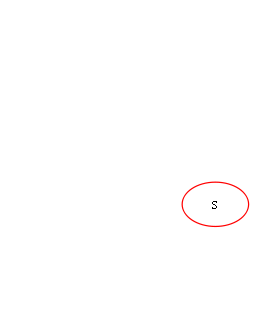

In [11]:
interactive( ga )    

Here we see the graph being generated. Steps 15-17 show precicely how the expression "z - s" is found to have occured before, and so the node and its connections are removed, and the identifier to which it is assigned ("t") is added as an additional identifier for "x".

In [12]:
# this code generates a gif in the current directory

graphs = ga.graphs()
files = render(graphs, 'dag')
gif(files, 'dag', 50)

## References
1. Kakde, O.G. Algorithms for Compiler Design. 2002. Chapter 10.6 
2. Scott, M.L. Programming Language Pragmatics. 2009. Chapter 16 - Code Improvement
3. Pfenning, F. Lecture Notes on Common Subexpression Elimination. 2015 
4. GraphvizAnim. https://github.com/mapio/GraphvizAnim
